In [3]:
import numpy as np
from tqdm import tqdm
import random as rd

In [4]:
RBP='1A34 1AQ3 1BMV 1F7V 1H4Q 1JBT 1L9A 1MZP 1WMQ 1YYK 1ZL3 2ANN 2ATW 2AZ2 2BX2 2DR2 2DU4 2G4B 2GXB 3AMT'
#the rbp we gonna analyze
rbp=RBP.split()
len(rbp)

20

In [5]:
name=[]
for i in range(20):
    f = open(rbp[i]+'/complex1.pdb')
    for x in f.readlines():
        if x.split()[3] not in name:
            name.append(x.split()[3])
    f.close()
len(name)

38

In [6]:
protein = ['THR',
 'GLY',
 'ASP',
 'ASN',
 'SER',
 'VAL',
 'MET',
 'ILE',
 'ARG',
 'ALA',
 'TYR',
 'PRO',
 'LYS',
 'TRP',
 'PHE',
 'GLU',
 'GLN',
 'LEU',
 'HIS',
 'CYS',
 'A',
 'G',
 'C',
 'U']

In [7]:
num = 24
comp_num = 1000
total = 20*comp_num

In [8]:
#measure the size of the RBP

size=np.zeros([20,comp_num,6])
for i in tqdm(range(20)):#for every rbp
    for j in range(comp_num):
        r=rbp[i]
        f = open(r+'/complex%d.pdb'%(j+1))
        tmp_x = []
        tmp_y = []
        tmp_z = []
        for x in f.readlines():
            tmp_z.append(np.float32(x[-9:-1]))
            tmp_y.append(np.float32(x[-17:-9]))
            tmp_x.append(np.float32(x[-25:-17]))
        size[i,j,0]=max(tmp_x)
        size[i,j,3]=min(tmp_x)
        size[i,j,1]=max(tmp_y)
        size[i,j,4]=min(tmp_y)
        size[i,j,2]=max(tmp_z)
        size[i,j,5]=min(tmp_z)


  0%|          | 0/20 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [47]:
length=np.zeros([20,comp_num,3])
length[:,:,0]=(size[:,:,0]-size[:,:,3])/num
length[:,:,1]=(size[:,:,1]-size[:,:,4])/num
length[:,:,2]=(size[:,:,2]-size[:,:,5])/num
for k in tqdm(range(20)):#for every rbp
    coordinate=np.zeros((comp_num,num,num,num,24),dtype = int)
    for j in range(comp_num):
        r=rbp[k]
        f = open(r+'/complex%d.pdb'%(j+1))
        t=f.readlines()[0].split()[-4]
        cotmp=np.zeros(4)
        f = open(r+'/complex%d.pdb'%(j+1))
        for x in f.readlines():
            #print(x)
            if x[22:26]!=t and cotmp[3]!=0:
                #print(cotmp,t,tmp)
                position = cotmp[0:3]/cotmp[3]-size[k,j,3:]
                #print(cotmp[0:3]/cotmp[3])
                ix=position[0]//length[k,j,0]
                iy=position[1]//length[k,j,1]
                iz=position[2]//length[k,j,2]
                #if ix > 10:
                    #print(k,j,position)
                if i < 24:
                    coordinate[j,int(ix),int(iy),int(iz),i]+=1
                cotmp=np.zeros(4)
            #save center of the acid or RNA in coord

            tmp=np.zeros(4)
            tmp[2]+=np.float32(x[-9:-1])
            tmp[1]+=np.float32(x[-17:-9])
            tmp[0]+=np.float32(x[-25:-17])
            tmp[3]+=1
            #print(tmp)
            cotmp+=tmp

            #count every atom in each acid or RNA

            n =x.split()[3]
            i = name.index(n)     
            t =x[22:26]
            #update the tmp index 
    coordi = coordinate.reshape([comp_num,num*num*num*24])
    np.savetxt(protein[k]+'24',coordi,fmt = '%.0e')
    f.close() 

100%|██████████| 20/20 [57:06<00:00, 168.85s/it]


In [8]:
index = list(range(total))
rd.shuffle(index)
train_index = index[:-300]
test_index = index[-300:]

In [9]:
train_coordinate = coordinate.reshape(20*comp_num,num,num,num,24)[train_index]
test_coordinate = coordinate.reshape(20*comp_num,num,num,num,24)[test_index]

In [13]:
target = np.zeros((20,comp_num))

for k in range(20):
    tmp=[]
    f=open(rbp[k]+'/'+rbp[k]+'.rmsd.out.tensorflow')
    for x in f.readlines()[1:]:
        tmp.append(np.float32(x[23:32]))
    target[k]=np.float32(tmp[0:comp_num])

In [11]:
train_target = target.reshape(20*comp_num,1)[train_index]
test_target = target.reshape(20*comp_num,1)[test_index]

In [9]:
import tensorflow as tf
sess = tf.InteractiveSession()

In [7]:
x = tf.placeholder(tf.float32, shape=[None,  num, num, num, 24], name='x_')
y_ = tf.placeholder(tf.float32, shape=[None, 1], name='y_')

In [8]:
num

24

In [9]:
def conv3d(x, W):
    return tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME')

def max_pool_2x2x2(x,layer_name):
    with tf.name_scope(layer_name):
        pool = tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1],
                            strides=[1, 2, 2, 2, 1], padding='SAME',name='pool')
        tf.summary.histogram('pool', pool)
        return pool
    
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)
def random_batch(data,label,size):
    index =  np.random.choice(len(label), size, replace=False)
    batch_data = data[index]
    batch_label = label[index]
    return batch_data,batch_label

def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)
        
def conv_layer(input_tensor,weight_dim, input_dim, output_dim, layer_name, act=tf.nn.relu):
    """Reusable code for making a simple neural net layer.

    It does a matrix multiply, bias add, and then uses relu to nonlinearize.
    It also sets up name scoping so that the resultant graph is easy to read,
    and adds a number of summary ops.
    """
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([weight_dim[0],weight_dim[1],weight_dim[2], input_dim,output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = conv3d(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
        return activations
    
def dropout_layer(x,layer_name,keep_prob=0.5):
    with tf.name_scope(layer_name):
        drop = tf.nn.dropout(x, keep_prob)
        tf.summary.histogram('dropped', drop)
        return drop
    

def nn_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.relu):
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
    # This Variable will hold the state of the weights for the layer
        with tf.name_scope('weights'):
            weights = weight_variable([input_dim, output_dim])
            variable_summaries(weights)
        with tf.name_scope('biases'):
            biases = bias_variable([output_dim])
            variable_summaries(biases)
        with tf.name_scope('Wx_plus_b'):
            preactivate = tf.matmul(input_tensor, weights) + biases
            tf.summary.histogram('pre_activations', preactivate)
    activations = act(preactivate, name='activation')
    tf.summary.histogram('activations', activations)
    return activations

In [10]:
x_image = tf.cast(tf.reshape(x, [-1, num, num, num, 24]),tf.float32)

In [11]:
h_conv1 = conv_layer(x_image,[3,3,3],24,32,'conv1')
h_conv2 = conv_layer(h_conv1,[6,6,6],32,32,'conv2')
h_pool1 = max_pool_2x2x2(h_conv2,'pool1')

h_conv3 = conv_layer(h_pool1,[4,4,4],32,32,'conv3')
h_conv4 = conv_layer(h_conv3,[5,5,5],32,32,'conv4')
h_pool2 = max_pool_2x2x2(h_conv4,'pool2')

In [12]:
h_flat1 = tf.reshape(h_pool2, [-1, int(num * num* num /2)])
h_fc1 = nn_layer(h_flat1,int(num * num* num /2),256,'fc1')


In [13]:
keep_prob = tf.placeholder(tf.float32, name='keep_prob0')
h_drop = dropout_layer(h_fc1,'dropout', keep_prob)

In [14]:
y_conv = nn_layer(h_drop,256,1,'output')


W_conv1 = weight_variable([3, 3, 3, 24, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv3d(x_image, W_conv1) + b_conv1)

W_conv2 = weight_variable([5, 5, 5, 32, 32])
b_conv2 = bias_variable([32])
h_conv2 = tf.nn.relu(conv3d(h_conv1, W_conv2) + b_conv2)

h_pool1 = max_pool_2x2x2(h_conv1)

W_conv3 = weight_variable([4, 4, 4, 32, 32])
b_conv3 = bias_variable([32])
h_conv3 = tf.nn.relu(conv3d(h_pool1, W_conv3) + b_conv3)

W_conv4 = weight_variable([5, 5, 5, 32, 32])
b_conv4 = bias_variable([32])
h_conv4 = tf.nn.relu(conv3d(h_conv3, W_conv4) + b_conv4)

h_pool2 = max_pool_2x2x2(h_conv4)

W_fc1 = weight_variable([int(num* num *num/2), 128])
b_fc1 = bias_variable([128])

h_pool2_flat = tf.reshape(h_pool2, [-1, int(num * num* num /2)])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

keep_prob = tf.placeholder(tf.float32, name='keep_prob0')
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([128, 128])
b_fc2 = bias_variable([128])

y_conv = tf.abs(tf.add(tf.matmul(h_fc1_drop, W_fc2) , b_fc2),name='y_conv')

In [15]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.squared_difference(y_,y_conv), name='loss')
    tf.summary.scalar('loss',loss)

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(5e-5).minimize(loss)
    
saver = tf.train.Saver()


merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter( './my-model9/train',
                                      sess.graph)
test_writer = tf.summary.FileWriter('./my-model9/test')

In [48]:
tf.global_variables_initializer().run()

size = 30

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(3001):
        batch = random_batch(train_coordinate,train_target,size)
        summary, _ = sess.run([merged, train_step],feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})  
        train_writer.add_summary(summary, i)
        if i % 50 == 0:
            #train_accuracy = accuracy.eval(feed_dict={
                  #x: np.float32(coordinate), y_: np.float32(target), keep_prob: 1.0})
            test_batch = random_batch(test_coordinate,test_target,50)
            summary, los = sess.run([merged, loss], feed_dict={
                  x: test_batch[0], y_: test_batch[1], keep_prob: 1.0})
            test_writer.add_summary(summary, i)
            print('step %d, test loss %g' % (i, los))
            #print('step %d, min pred %g' % (i, min(y_conv.eval(feed_dict={
            #      x: test_batch[0], y_: test_batch[1], keep_prob: 1.0}))))
        if i % 500 == 0:    
            saver.save(sess, './my-model9/iter %d'%i)


step 0, test loss 2539.63
step 50, test loss 609.166
step 100, test loss 365.378
step 150, test loss 387.944
step 200, test loss 336.31
step 250, test loss 219.58
step 300, test loss 314.083
step 350, test loss 156.367
step 400, test loss 252.825
step 450, test loss 172.949
step 500, test loss 235.103
step 550, test loss 199.1
step 600, test loss 272.376
step 650, test loss 155.669
step 700, test loss 289.078
step 750, test loss 179.893
step 800, test loss 155.38
step 850, test loss 231.538
step 900, test loss 92.6684
step 950, test loss 128.428
step 1000, test loss 124.673
step 1050, test loss 153.558
step 1100, test loss 165.869
step 1150, test loss 110.932
step 1200, test loss 101.958
step 1250, test loss 215.509
step 1300, test loss 159.026
step 1350, test loss 141.747
step 1400, test loss 137.719
step 1450, test loss 85.4829
step 1500, test loss 98.5884
step 1550, test loss 159.801
step 1600, test loss 132.105
step 1650, test loss 131.271
step 1700, test loss 161.782
step 1750, te

In [10]:
import pickle

def test_model(test_coordinate,test_target):
    """
    Test the saved model against the test dataset
    """
    save_model_path = './my-model6'
    #test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)
    
        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x_:0')
        loaded_y = loaded_graph.get_tensor_by_name('y_:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob0:0')
        loaded_loss = loaded_graph.get_tensor_by_name('loss:0')
        loaded_yconv = loaded_graph.get_tensor_by_name('y_conv:0')

        predict_y = loaded_yconv.eval(feed_dict={loaded_x: test_coordinate,
                                       loaded_y: test_target, loaded_keep_prob: 1.0})
        real_y = loaded_y.eval(feed_dict={loaded_x: test_coordinate,
                                       loaded_y: test_target, loaded_keep_prob: 1.0})       
        #print(tf.nn.top_k(conseq,10,sorted=False))
    return predict_y,real_y

In [11]:
tf.logging.set_verbosity(tf.logging.WARN)

In [14]:
a = np.zeros([20,1000,2])
for i in tqdm(range(20)):
    test_data = np.loadtxt(protein[i]+'24')
    for j in range(20):
        l = int(comp_num/20)
        test_coordinate = test_data[j*l:j*l+l].reshape([l,num,num,num,24])
        test_target = target[i,j*l:j*l+l].reshape([l,1])
        a[i,j*l:j*l+l,0]=test_model(test_coordinate,test_target)[0].reshape([l])
        a[i,j*l:j*l+l,1]=test_target.reshape([l])


100%|██████████| 20/20 [1:49:49<00:00, 326.82s/it]


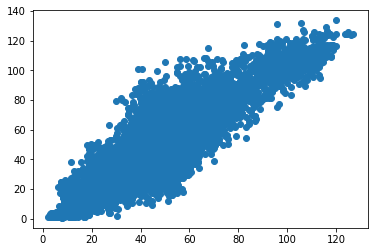

In [19]:
b = a.reshape([20000,2])
import matplotlib.pyplot as plt
plt.scatter(b[:,0],b[:,1])
plt.show()

In [22]:
import math
def linefit(x , y):
    N = float(len(x))
    sx,sy,sxx,syy,sxy=0,0,0,0,0
    for i in range(0,int(N)):
        sx  += x[i]
        sy  += y[i]
        sxx += x[i]*x[i]
        syy += y[i]*y[i]
        sxy += x[i]*y[i]
    a = (sy*sx/N -sxy)/( sx*sx/N -sxx)
    b = (sy - a*sx)/N
    r = abs(sy*sx/N-sxy)/math.sqrt((sxx-sx*sx/N)*(syy-sy*sy/N))
    return a,b,r

In [24]:
linefit(b[:,0],b[:,1])

(1.0311880791554344, 0.17736816883313586, 0.90151415178234207)